<a href="https://colab.research.google.com/github/Fazi91/Chatbot/blob/main/notebooks/how-tos/dataloading_buffers_replay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
description: How to implement replay and data loading
---
# Dataloading, Memory Buffers, and Replay

Avalanche provides several components that help you to balance data loading and implement rehearsal strategies.

**Dataloaders** are used to provide balancing between groups (e.g. tasks/classes/experiences). This is especially useful when you have unbalanced data.

**Buffers** are used to store data from the previous experiences. They are dynamic datasets with a fixed maximum size, and they can be updated with new data continuously.

Finally, **Replay** strategies implement rehearsal by using Avalanche's plugin system. Most rehearsal strategies use a custom dataloader to balance the buffer with the current experience and a buffer that is updated for each experience.

First, let's install Avalanche. You can skip this step if you have installed it already.

In [ ]:
!pip install avalanche-lib

## Dataloaders
Avalanche dataloaders are simple iterators, located under `avalanche.benchmarks.utils.data_loader`. Their interface is equivalent to pytorch's dataloaders. For example, `GroupBalancedDataLoader` takes a sequence of datasets and iterates over them by providing balanced mini-batches, where the number of samples is split equally among groups. Internally, it instantiate a `DataLoader` for each separate group. More specialized dataloaders exist such as `TaskBalancedDataLoader`.

All the dataloaders accept keyword arguments (`**kwargs`) that are passed directly to the dataloaders for each group.

In [ ]:
from avalanche.benchmarks import SplitMNIST
from avalanche.benchmarks.utils.data_loader import GroupBalancedDataLoader
benchmark = SplitMNIST(5, return_task_id=True)

dl = GroupBalancedDataLoader([exp.dataset for exp in benchmark.train_stream], batch_size=5)
for x, y, t in dl:
    print(t.tolist())
    break


[0, 1, 2, 3, 4]


## Memory Buffers
Memory buffers store data up to a maximum capacity, and they implement policies to select which data to store and which the to remove when the buffer is full. They are available in the module `avalanche.training.storage_policy`. The base class is the `ExemplarsBuffer`, which implements two methods:
- `update(strategy)` - given the strategy's state it updates the buffer (using the data in `strategy.experience.dataset`).
- `resize(strategy, new_size)` - updates the maximum size and updates the buffer accordingly.

The data can be access using the attribute `buffer`.

In [ ]:
from avalanche.training.storage_policy import ReservoirSamplingBuffer
from types import SimpleNamespace

benchmark = SplitMNIST(5, return_task_id=False)
storage_p = ReservoirSamplingBuffer(max_size=30)

print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")

Max buffer size: 30, current size: 0


At first, the buffer is empty. We can update it with data from a new experience.

Notice that we use a `SimpleNamespace` because we want to use the buffer standalone, without instantiating an Avalanche strategy. Reservoir sampling requires only the `experience` from the strategy's state.

In [ ]:
for i in range(5):
    strategy_state = SimpleNamespace(experience=benchmark.train_stream[i])
    storage_p.update(strategy_state)
    print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")
    print(f"class targets: {storage_p.buffer.targets.uniques}\n")

Max buffer size: 30, current size: 30
class targets: {8, 7}

Max buffer size: 30, current size: 30
class targets: {8, 0, 5, 7}

Max buffer size: 30, current size: 30
class targets: {0, 1, 2, 5, 7, 8}

Max buffer size: 30, current size: 30
class targets: {0, 1, 2, 3, 5, 7, 8, 9}

Max buffer size: 30, current size: 30
class targets: {0, 1, 2, 3, 5, 6, 7, 8, 9}



Notice after each update some samples are substituted with new data. Reservoir sampling select these samples randomly.

Avalanche offers many more storage policies. For example, `ParametricBuffer` is a buffer split into several groups according to the `groupby` parameters (`None`, 'class', 'task', 'experience'), and according to an optional `ExemplarsSelectionStrategy` (random selection is the default choice).

In [ ]:
from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
storage_p = ParametricBuffer(
    max_size=30,
    groupby='class',
    selection_strategy=RandomExemplarsSelectionStrategy()
)

print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")
for i in range(5):
    strategy_state = SimpleNamespace(experience=benchmark.train_stream[i])
    storage_p.update(strategy_state)
    print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")
    print(f"class targets: {storage_p.buffer.targets.uniques}\n")

Max buffer size: 30, current size: 0
Max buffer size: 30, current size: 30
class targets: {8, 7}

Max buffer size: 30, current size: 30
class targets: {8, 0, 5, 7}

Max buffer size: 30, current size: 30
class targets: {0, 1, 2, 5, 7, 8}

Max buffer size: 30, current size: 30
class targets: {0, 1, 2, 3, 5, 7, 8, 9}

Max buffer size: 30, current size: 30
class targets: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}



The advantage of using grouping buffers is that you get a balanced rehearsal buffer. You can even access the groups separately with the `buffer_groups` attribute. Combined with balanced dataloaders, you can ensure that the mini-batches stay balanced during training.

In [ ]:
for k, v in storage_p.buffer_groups.items():
    print(f"(group {k}) -> size {len(v.buffer)}")

(group 7) -> size 3
(group 8) -> size 3
(group 5) -> size 3
(group 0) -> size 3
(group 1) -> size 3
(group 2) -> size 3
(group 9) -> size 3
(group 3) -> size 3
(group 4) -> size 3
(group 6) -> size 3


In [ ]:
datas = [v.buffer for v in storage_p.buffer_groups.values()]
dl = GroupBalancedDataLoader(datas)

for x, y, t in dl:
    print(y.tolist())
    break

[7, 7, 7, 8, 8, 8, 5, 5, 5, 0, 0, 0, 1, 1, 1, 2, 2, 2, 9, 9, 9, 3, 3, 3, 4, 4, 4, 6, 6, 6]


## Replay Plugins

Avalanche's strategy plugins can be used to update the rehearsal buffer and set the dataloader. This allows to easily implement replay strategies:

In [ ]:
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from avalanche.training.plugins import SupervisedPlugin

class CustomReplay(SupervisedPlugin):
    def __init__(self, storage_policy):
        super().__init__()
        self.storage_policy = storage_policy

    def before_training_exp(self, strategy,
                            num_workers: int = 0, shuffle: bool = True,
                            **kwargs):
        """ Here we set the dataloader. """
        if len(self.storage_policy.buffer) == 0:
            # first experience. We don't use the buffer, no need to change
            # the dataloader.
            return

        # replay dataloader samples mini-batches from the memory and current
        # data separately and combines them together.
        print("Override the dataloader.")
        strategy.dataloader = ReplayDataLoader(
            strategy.adapted_dataset,
            self.storage_policy.buffer,
            oversample_small_tasks=True,
            num_workers=num_workers,
            batch_size=strategy.train_mb_size,
            shuffle=shuffle)

    def after_training_exp(self, strategy: "BaseStrategy", **kwargs):
        """ We update the buffer after the experience.
            You can use a different callback to update the buffer in a different place
        """
        print("Buffer update.")
        self.storage_policy.update(strategy, **kwargs)


And of course, we can use the plugin to train our continual model

In [39]:
from torch.nn import CrossEntropyLoss
from avalanche.training import Naive
from avalanche.evaluation.metrics import accuracy_metrics
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.models import SimpleMLP
import torch

scenario = SplitMNIST(5)
model = SimpleMLP(num_classes=scenario.n_classes)
storage_p = ParametricBuffer(
    max_size=500,
    groupby='class',
    selection_strategy=RandomExemplarsSelectionStrategy()
)

# choose some metrics and evaluation method
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loggers=[interactive_logger])

# CREATE THE STRATEGY INSTANCE (NAIVE)
cl_strategy = Naive(model, torch.optim.Adam(model.parameters(), lr=0.001),
                    CrossEntropyLoss(),
                    train_mb_size=100, train_epochs=1, eval_mb_size=100,
                    plugins=[CustomReplay(storage_p)],
                    evaluator=eval_plugin
                    )

# TRAINING LOOP
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience ", experience.current_experience)
    cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    results.append(cl_strategy.eval(scenario.test_stream))

/usr/local/lib/python3.11/dist-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


Starting experiment...
Start of experience  0
-- >> Start of training phase << --
100%|██████████| 121/121 [00:03<00:00, 32.62it/s]
Epoch 0 ended.
Buffer update.
-- >> End of training phase << --


<ipython-input-29-04bf1c5bdbc6>:34: DeprecationWarning: Call to deprecated function update (removal in version 0.7: switch to pre_adapt and post_adapt)
  self.storage_policy.update(strategy, **kwargs)


Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 39.96it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9837
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 19/19 [00:01<00:00, 14.12it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 22/22 [00:02<00:00,  9.30it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0000
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 20/20 [00:01<00:00, 14.88it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.0000


<ipython-input-29-04bf1c5bdbc6>:34: DeprecationWarning: Call to deprecated function update (removal in version 0.7: switch to pre_adapt and post_adapt)
  self.storage_policy.update(strategy, **kwargs)



Epoch 0 ended.
Buffer update.
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 38.64it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9460
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 19/19 [00:00<00:00, 41.67it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9741
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 41.79it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0000
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 39.18it/s]
> Eval on experience 3 (Task 0) from test stream end

<ipython-input-29-04bf1c5bdbc6>:34: DeprecationWarning: Call to deprecated function update (removal in version 0.7: switch to pre_adapt and post_adapt)
  self.storage_policy.update(strategy, **kwargs)


100%|██████████| 21/21 [00:00<00:00, 41.32it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8638
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 19/19 [00:00<00:00, 42.86it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9211
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 41.85it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.9857
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 41.27it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.0000
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 41.87it/s]
> Eval on experience 4 (Task 0) from test st

<ipython-input-29-04bf1c5bdbc6>:34: DeprecationWarning: Call to deprecated function update (removal in version 0.7: switch to pre_adapt and post_adapt)
  self.storage_policy.update(strategy, **kwargs)


-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 39.04it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7509
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 19/19 [00:00<00:00, 36.97it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8411
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 29.20it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.9528
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 29.18it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/te

<ipython-input-29-04bf1c5bdbc6>:34: DeprecationWarning: Call to deprecated function update (removal in version 0.7: switch to pre_adapt and post_adapt)
  self.storage_policy.update(strategy, **kwargs)



Epoch 0 ended.
Buffer update.
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 41.39it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7647
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 19/19 [00:00<00:00, 41.07it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7216
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 39.45it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.8793
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 40.67it/s]
> Eval on experience 3 (Task 0) from test stream end

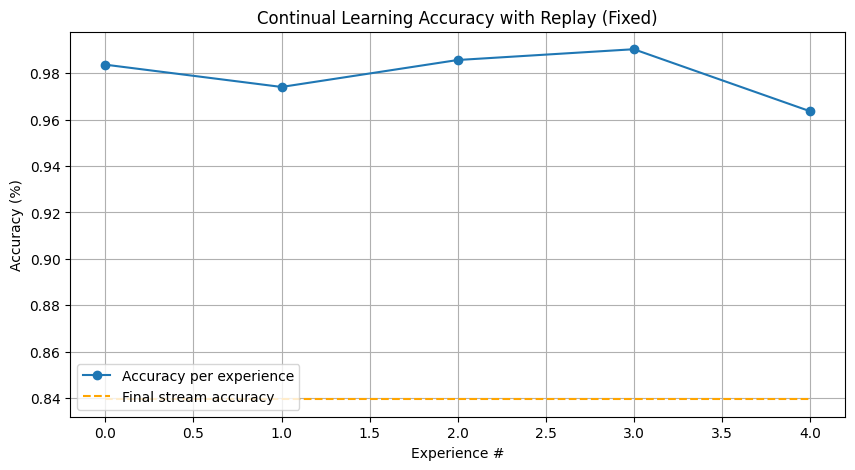

In [40]:
import matplotlib.pyplot as plt

accuracies_per_exp = []
for i in range(len(results)):
    exp_key = f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{i}"
    if exp_key in results[i]:
        accuracies_per_exp.append(results[i][exp_key])

# فقط یکی از stream accuracy رو بگیر
stream_accuracy = results[-1]["Top1_Acc_Stream/eval_phase/test_stream/Task000"]

# رسم
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(accuracies_per_exp, marker='o', label='Accuracy per experience')
plt.hlines(stream_accuracy, 0, len(accuracies_per_exp)-1,
           linestyles='--', label='Final stream accuracy', colors='orange')
plt.xlabel("Experience #")
plt.ylabel("Accuracy (%)")
plt.title("Continual Learning Accuracy with Replay (Fixed)")
plt.legend()
plt.grid(True)
plt.show()